In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt 

In [2]:
Image_size = 256
Batch_size = 32
Channels = 3
epochs = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (Image_size,Image_size),
    batch_size = Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 0 2 1 1 0 1 2 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0]


In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[2].numpy())
    print(image_batch[2].shape)

[[[206. 209. 218.]
  [203. 206. 215.]
  [199. 202. 211.]
  ...
  [145. 141. 155.]
  [128. 124. 138.]
  [123. 119. 133.]]

 [[198. 201. 210.]
  [197. 200. 209.]
  [197. 200. 209.]
  ...
  [119. 115. 129.]
  [133. 129. 143.]
  [147. 143. 157.]]

 [[200. 203. 212.]
  [202. 205. 214.]
  [204. 207. 216.]
  ...
  [145. 141. 155.]
  [119. 115. 129.]
  [168. 164. 178.]]

 ...

 [[155. 157. 170.]
  [156. 158. 171.]
  [158. 160. 173.]
  ...
  [104. 102. 113.]
  [143. 141. 152.]
  [151. 149. 160.]]

 [[157. 159. 172.]
  [157. 159. 172.]
  [158. 160. 173.]
  ...
  [140. 138. 149.]
  [154. 152. 163.]
  [115. 113. 124.]]

 [[156. 158. 171.]
  [156. 158. 171.]
  [155. 157. 170.]
  ...
  [156. 154. 165.]
  [140. 138. 149.]
  [144. 142. 153.]]]
(256, 256, 3)


In [7]:
def show_image(n):
    
    plt.figure(figsize=(12,12))
    for image_batch, label_batch in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(3,4,i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[label_batch[i]])


In [8]:
show_image(10)

In [9]:
def get_dataset_paartitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000 ):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12 )

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, test_ds, val_ds

In [10]:
train_ds, test_ds, val_ds = get_dataset_paartitions_tf(dataset)

In [11]:
len(train_ds), len(test_ds), len(val_ds)

(54, 6, 6)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_size, Image_size),
    layers.Rescaling(1.0/255)
]) 

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
input_shape = (Batch_size,Image_size,Image_size,Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape = input_shape)

E:\MY LLM\cuda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs = epochs,
    batch_size = Batch_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4579 - loss: 0.9296 - val_accuracy: 0.6094 - val_loss: 0.8045
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6346 - loss: 0.7264 - val_accuracy: 0.7188 - val_loss: 0.6742
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7648 - loss: 0.5614 - val_accuracy: 0.8021 - val_loss: 0.5507
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8165 - loss: 0.4149 - val_accuracy: 0.8958 - val_loss: 0.3219
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 969ms/step - accuracy: 0.8738 - loss: 0.3088 - val_accuracy: 0.8906 - val_loss: 0.2808
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 960ms/step - accuracy: 0.8956 - loss: 0.2683 - val_accuracy: 0.9427 - val_loss: 0.1738
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 960ms/step - accuracy: 0.9242 - loss: 0.1851 - val_accuracy: 0.9271 - val_loss: 0.2164
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 982ms/step - accuracy: 0.9113 - loss: 0.2331 - val_accuracy: 0.9115

In [19]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.9135 - loss: 0.2068


In [20]:
scores

[0.20233510434627533, 0.90625]

In [21]:
history

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Traning and validation Loss')

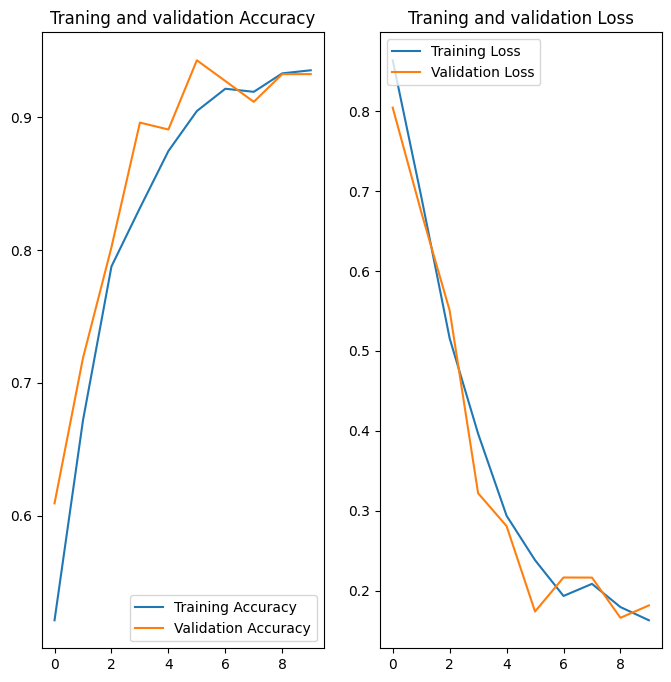

In [23]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label = 'Training Accuracy')
plt.plot(range(epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc ='lower right')
plt.title('Traning and validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label = 'Training Loss')
plt.plot(range(epochs), val_loss, label = 'Validation Loss')
plt.legend(loc ='upper left')
plt.title('Traning and validation Loss')

first image to predict
first image's actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
predicted label: Potato___Early_blight


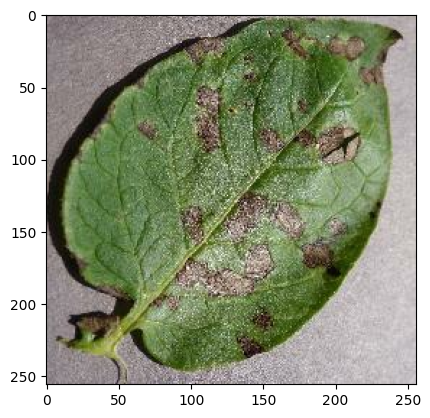

In [24]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:" , class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print( "predicted label:", class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


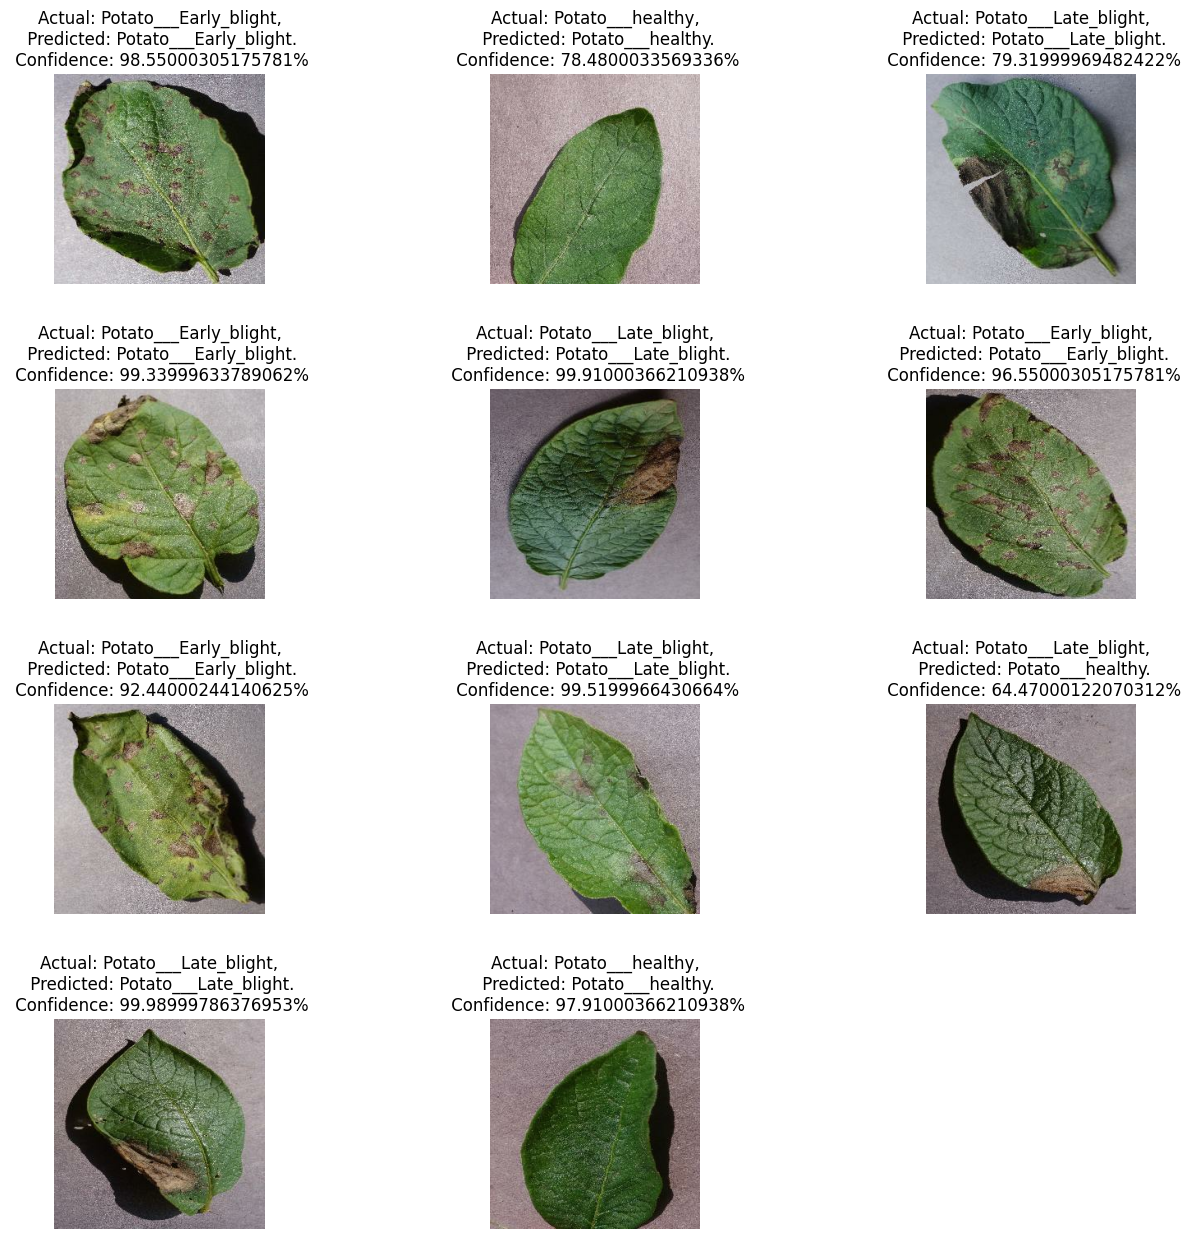

In [26]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(11):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        
# Adjust the space between the plots
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust hspace and wspace as needed
plt.show()        

In [28]:
""" import os
from tensorflow import keras

# Determine the next model version
model_versions = [int(i) for i in os.listdir("./Model") if i.isdigit()]
model_version = max(model_versions, default=0) + 1

# Save the model with .keras extension
model.save(f"./Model/{model_version}.keras") """


' import os\nfrom tensorflow import keras\n\n# Determine the next model version\nmodel_versions = [int(i) for i in os.listdir("./Model") if i.isdigit()]\nmodel_version = max(model_versions, default=0) + 1\n\n# Save the model with .keras extension\nmodel.save(f"./Model/{model_version}.keras") '